Comparison of Disaster tweets : 
The aim of this notebook is to classify tweets potentially related to catastrophes into real or misleading tweets. Here comparison between several ML techniques will be also done.

In [12]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import string
import nltk
import re # regular expressions

In [13]:
#!pip install pyspellchecker

In [100]:
#from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arijit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
#!ls sample_data

In [17]:
#!cp test.csv train.csv sample_data

In [18]:
# training data
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [50]:
train_len = len(data)

In [20]:
# test data
tdata = pd.read_csv('test.csv')
tdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [21]:
print('training data shape: {}, test data shape: {}'.format(data.shape, tdata.shape))

training data shape: (7613, 5), test data shape: (3263, 4)


In [22]:
#combine training & test data, but dont shuffale
total_data = pd.concat([data, tdata], sort=False)
total_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [23]:
# check the missing data 
total_data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [24]:
# so there are lot of missing values

In [25]:
print('unique values in keyword {}, location {}'.format(total_data.keyword.nunique(), total_data.location.nunique()))

unique values in keyword 221, location 4521


In [113]:
# check the distribution of target if there they are uneven 
def show_target_barplot():
  """ plot target distribution """
  target_types = data.target.value_counts()
  plot = sb.barplot(y=target_types, x=data.target.value_counts().index)
  plot.set_title('target distribution')

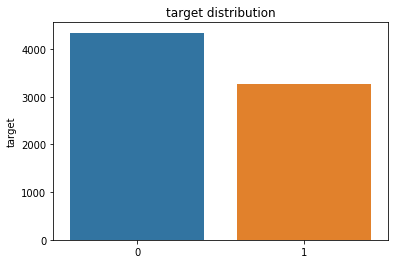

In [114]:
show_target_barplot()

'target' type counts looks to be not too deviated.

In [28]:
# Analyze the keyword & location feature and fill the missing values
def plot_keyword_location():
  fig, ax =plt.subplots(1,2)
  fig.subplots_adjust(hspace=0.5 , wspace=0.5)

  target_types = data.keyword.value_counts()[:10]
  # check for first few common names
  plot = sb.barplot(x=target_types, y=data.keyword.value_counts()[:10].index, ax=ax[0])
  plot.set_title('keyword types')

  location_types = data.location.value_counts()[:10]
  plot2 = sb.barplot(x=location_types, y=data.location.value_counts()[:10].index, ax=ax[1])
  plot2.set_title('location types')

  fig.show()

C:\Users\arijit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


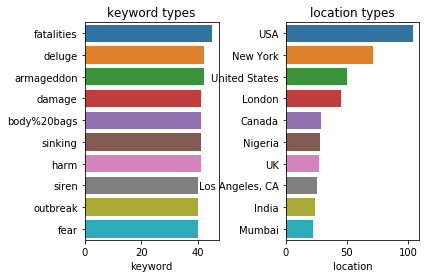

In [29]:
plot_keyword_location()

In [30]:
def fill_misiing_val():
  """ fill missing values with None """
  total_data.location.fillna('None', inplace=True)
  total_data.keyword.fillna('None', inplace=True)

  total_data.target.fillna(0, inplace=True)

fill_misiing_val()

In [31]:
total_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [32]:
total_data.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0


Data is now ready for cleaning

This data is having all weblinks and spaces as well
*   Need to clean the text *data*
*   remove punctuations
*   List item
*   lower case 
*   remove 







In [76]:
def remove_punctuations_and_nums(text):
  """ remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and numbers """
  clean_data = ''.join([x for x in text if x not in string.punctuation])
  clean_data = ''.join([x for x in clean_data if x not in string.digits])
  return clean_data

def remove_stopwords(text):
  clean_data = ''.join([x for x in text if x not in nltk.corpus.stopwords.words('english')])
  return clean_data

def remove_weblinks(text):
  clean_data = re.sub('www.|https://|http://|.com|t.co/','', text)
  return clean_data

def remove_nonascii(text):
  clean_text = ''.join([x for x in text if ord(x) < 128])
  return clean_text

#spell = SpellChecker()
def correct_spelling(text):
  """ spelling correction """
  mispelled = spell.unknown(text.split())

  correct_text = []
  for word in text.split():
    if word in mispelled:
      correct_text.append(spell.correction(word))
    else:
      correct_text.append(word)

  return correct_text

def clean_text(data):
  # convert to lower case
  data['clean_text'] = data['text'].apply(lambda x: x.lower())
  print('lower case')
  # remove punc & digits
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_punctuations_and_nums(x))
  # remove stopwords
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
  # remove all web links
  #data['clean_text'] = data['clean_text'].apply(lambda x: remove_weblinks(x)) # takes time
  # remove non ascii charecters
  #data['clean_text'] = data['clean_text'].apply(lambda x: remove_nonascii(x))
  # removing any leading and trailing whitespaces including tabs
  #data['clean_text'] = data['clean_text'].apply(lambda x: x.strip())

  # correct spelling
  # data['clean_text'] = data['clean_text'].apply(lambda x: correct_spelling(x)) #takes time to process
  
  

In [77]:
clean_text(total_data)

lower case


In [78]:
total_data.head()

,id,keyword,location,text,target,clean_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,ur ee re he ren f h erhquke llh frgve u ll
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,fre fre ner l rnge k cn
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,ll reen ke heler n plce re beng nfe b ffcer n...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,peple receve wlfre evcun rer n clfrn
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,ju g en h ph fr rub lk ke fr wlfre pur n chl


In [79]:
#save the cleaned data for future processing
total_data.to_csv('cleaned_data.csv')

In [80]:
# vectorize
def vectorize_text(text):
  # just skipping CountVectorizer 
  vec = TfidfVectorizer() #CountVectorizer() #TfidfVectorizer()
  vectorized_text = vec.fit_transform(text)
  return vec, vectorized_text

In [82]:
# Define a metrics function named get_metrics to evaluate the model's performance
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [83]:
def scaled_data(X, X_valid):
    from sklearn.preprocessing import StandardScaler
    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    X_valid = scaler_X.transform(X_valid)
    return X, X_valid, scaler_X  

In [137]:
"""
model_type : 
1 - Random forest(default)
2 - RidgeClassifier
3 - SVC
"""
#create a traditional sklearn model
def create_model(X, y, train_len, model_type=1):

  # split
  X_train = X[:train_len]
  X_test = X[train_len:]
  y_train = y[:train_len]
  y_test = y[train_len:]
  y_predict = []
  #X_train, X_test, y_train, y_test = train_test_split()
  # vectorize
  vec, X_train = vectorize_text(X_train)
  X_test = vec.transform(X_test)

  #X_Train, X_valid, scaler_X = scaled_data(X_train, X_test)
  #X_Test = scaler_X.transform(X_test)
    
  if model_type == 1: #RF classifier
    model = RandomForestClassifier(random_state=21)
    model.fit(X_train, y_train)
   
  elif model_type == 2: #RidgeClassifier
    model = RidgeClassifier(random_state=21)
    model.fit(X_train, y_train)
   
  elif model_type == 3: #SVC
    model = SVC(C=1.0, kernel='rbf',random_state=21)
    model.fit(X_train, y_train)
    
  cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
  y_predict = model.predict(X_test)
  #print("cross validation score:{}".format(cval))
  #accuracy, precision, recall, f1 = get_metrics(y_test, y_predict)  
  #print("accuracy {}, precision {}, recall {}, f1 {}".format(accuracy, precision, recall, f1))
  
  return y_predict

In [138]:
#read the saved data
df = pd.read_csv('cleaned_data.csv')
X = df['clean_text']
y = df['target']

#create_model(X, y, train_len, 1)
y_predict = create_model(X, y, train_len, 2) #RidgeClassifier
#create_model(X, y, train_len, 3) #svc

pandas.core.series.Series

In [136]:
#write the predictions to a file
predict = pd.DataFrame({'text':tdata['text'], 'prediction':y_predict})
predict.to_csv('final_prediction.csv')
